In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import env
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import sklearn.preprocessing

In [2]:
def acquire_zillow():
    '''
    This function will retrieve zillow home data for 2017 properties. It will only get
    single family residential properties. the function will attempt to open the data from 
    a local csv file, if one is not found, it will download the data from the codeup
    database. An env file is needed in the local directory in order to run this file.
    '''
    # check to see if a local csv of our data exists
    if os.path.exists('zillow_2017_sfr.csv'):
        print('opening data from local file')
        df = pd.read_csv('zillow_2017_sfr.csv', index_col=0)
    else:
        # if local file does not exist run sql query and write to csv
        print('local file not found')
        print('retrieving data from sql server')
        query = '''
    SELECT 
    bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
    taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    WHERE propertylandusetypeid IN(
        SELECT propertylandusetypeid
        FROM propertylandusetype
        WHERE propertylandusedesc = "Single Family Residential")
    -- LIMIT 1000
    ;
        '''
        connection = env.get_db_url('zillow')
        df = pd.read_sql(query, connection)
        df.to_csv('zillow_2017_sfr.csv')

    # renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',})
    return df

In [3]:
def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()

In [4]:
def remove_outliers(df, col_list, k=1.5):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [26]:
def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'taxamount'])
    
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    
    # converting column datatypes
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute year built using mode
    imputer = SimpleImputer(strategy='median')

    imputer.fit(train[['year_built']])

    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])       
    
    return train, validate, test    

In [6]:
def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    train, validate, test = prepare_zillow(acquire_zillow())
    
    return train, validate, test

opening data from local file


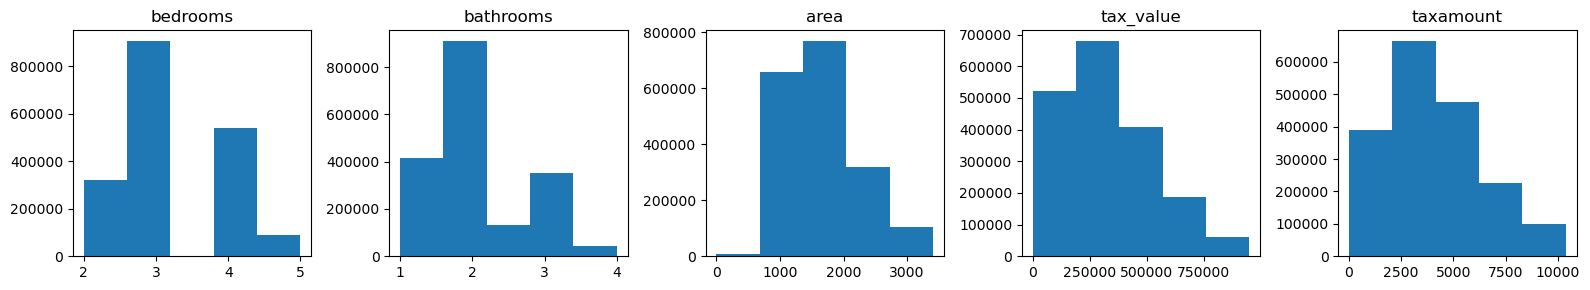

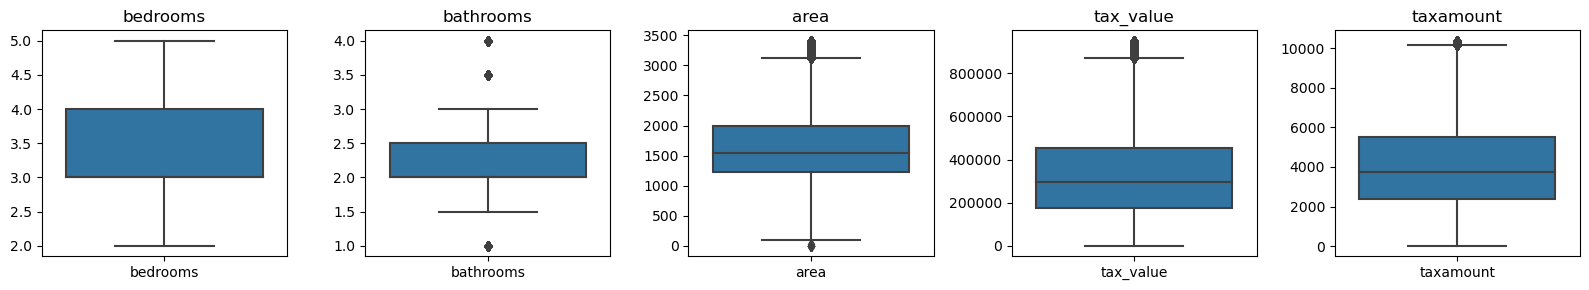

In [27]:
train, validate, test = wrangle_zillow()

In [8]:
import wrangle

opening data from local file


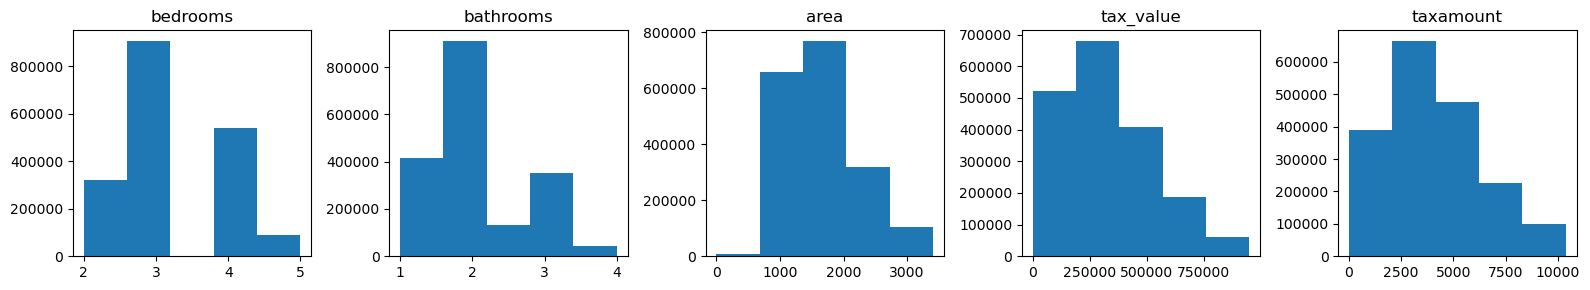

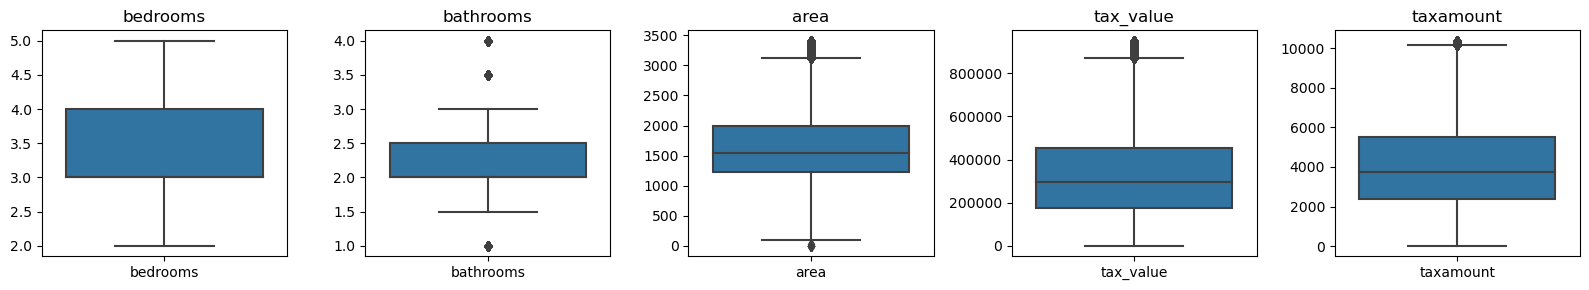

(         bedrooms  bathrooms    area  tax_value  year_built  taxamount    fips
 10057         4.0        2.0  1561.0   248240.0      1973.0    2504.40  6059.0
 2004969       3.0        2.0  1770.0    88390.0      1960.0    1671.93  6037.0
 306031        2.0        1.0  1452.0    81169.0      1946.0    1310.88  6037.0
 1038594       3.0        1.0  1000.0   119174.0      1950.0    1900.28  6037.0
 270959        3.0        2.0  1974.0   432268.0      1988.0    5315.27  6037.0
 ...           ...        ...     ...        ...         ...        ...     ...
 991121        3.0        1.0  1199.0   280857.0      1951.0    3282.40  6111.0
 1707758       4.0        2.0  1859.0    95008.0      1961.0    1463.61  6037.0
 1770245       3.0        3.0  2132.0   158470.0      1980.0    2037.38  6037.0
 1500740       2.0        1.0   780.0   477167.0      1955.0    6509.69  6037.0
 843328        3.0        1.0  1132.0   285700.0      1916.0    3563.75  6037.0
 
 [1038959 rows x 7 columns],
         

In [18]:
wrangle.wrangle_zillow()

In [15]:
def scale_zillow(train, val, test):
    '''
    this function will scale the numberical columns in the zillow dataset.
    This will take in the train, validate and test dataFrames, and will rescale the 
    area and taxamount columns using a MinMaxScaler, and add new columns to the 
    dataFrames with the scaled data.
    '''
    # create and fit a MinMaxScaler
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train['area'].values.reshape(-1,1))
    # create columns with the scaled data
    train['area_train_scaled'] = scaler.transform(train['area'].values.reshape(-1,1))
    val['area_validate_scaled'] = scaler.transform(val['area'].values.reshape(-1,1))
    test['area_test_scaled'] = scaler.transform(test['area'].values.reshape(-1,1))
    # creat and fit a MinMaxScaler
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train['taxamount'].values.reshape(-1,1))
    # create columns wiht the scaled data
    train['taxamount_train_scaled'] = scaler.transform(train['taxamount'].values.reshape(-1,1))
    val['taxamount_validate_scaled'] = scaler.transform(val['taxamount'].values.reshape(-1,1))
    test['taxamount_test_scaled'] = scaler.transform(test['taxamount'].values.reshape(-1,1))

In [16]:
scale_zillow(train, validate, test)

In [24]:
train[train['area'] == train['area'].min()]

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,area_train_scaled,taxamount_train_scaled
1359288,2.0,1.0,1.0,147577.0,1991.0,1855.4,6037.0,0.0,0.177182
